In [162]:
from __future__ import print_function

import os

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.datasets import mnist
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
batch_size = 10
num_classes = 10
epochs = 50

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [179]:
def make_model():
    """A really small model to illustrate the algorithm working"""
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['binary_accuracy', 'categorical_accuracy', 'mse'])
    return model

In [180]:
class LearningCurve:
    def __init__(self, model, batch_size, epochs=10):
        self.model = model
        self.init_weights = model.get_weights()
        self.results = {}
        self.batch_size = batch_size
        self.epochs = epochs
        
    def revert_model(self):
        self.model.set_weights(self.init_weights)
        self.model.reset_states()
        
    def fit(self, x_train, y_train, x_test, y_test, n_divs=5, verbose=1):
        idx = np.arange(len(x_train))
        np.random.shuffle(idx)
        num_data = len(x_train)
        data_step = num_data // n_divs
        
        
        for idx_end in np.floor(10 ** np.linspace(1,  np.log10(num_data), n_divs)).astype(int):
            idx_range = idx[:idx_end]
            self.revert_model()
            self.results[idx_end] = model.fit(x_train[idx_range], y_train[idx_range],
                batch_size=self.batch_size,
                epochs=self.epochs,
                verbose=verbose,
                validation_data=(x_test, y_test))
            
    def fit_generator(self, train_gen, x_test, y_test, n_divs=5, verbose=1):
        idx = np.arange(len(x_train))
        np.random.shuffle(idx)
        num_data = len(x_train)
        data_step = num_data // n_divs
        
        
        for idx_end in np.floor(10 ** np.linspace(1,  np.log10(num_data), n_divs)).astype(int):
            idx_range = idx[:idx_end]
            self.revert_model()
            self.results[idx_end] = model.fit(x_train[idx_range], y_train[idx_range],
                batch_size=self.batch_size,
                epochs=self.epochs,
                verbose=verbose,
                validation_data=(x_test, y_test))
            
    def plot(self):
        df = pd.DataFrame(
            [(metric_name, data_size, metric_value[-1])
            for data_size, result in self.results.items()
            for metric_name, metric_value in result.history.items()])
        df.columns = ['metric', 'data_size', 'value']
        df = df.pivot_table(index=['data_size'], columns=['metric'] )
        df.columns = df.columns.get_level_values(1)
        for col_name in df.columns:
            if col_name.startswith("val_"):
                continue
            if ("val_" + col_name) in df.columns:
                df[[col_name, "val_" + col_name]].plot(grid=True, logx=True, style='.-')
            else:
                df[[col_name]].plot(grid=True, logx=True, style='.-')
        return df

            

In [181]:
model = make_model()
model.summary()
learning_curve = LearningCurve(model, batch_size=10, epochs=5)
learning_curve.fit(
    x_train[::10], y_train[::10], x_test[::50], y_test[::50],
    n_divs=10,
    verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 16)        2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                23050     
Total params: 25,530
Trainable params: 25,530
Non-trainable params: 0
_________________________________________________________________


metric,binary_accuracy,categorical_accuracy,loss,mean_squared_error,val_binary_accuracy,val_categorical_accuracy,val_loss,val_mean_squared_error
data_size,,,,,,,,
10,0.900000,0.700000,0.429325,0.125451,0.9000,0.190,0.379250,0.107297
20,0.900000,0.400000,0.274467,0.076728,0.9000,0.180,0.330682,0.088947
41,0.900000,0.560976,0.259745,0.074944,0.9000,0.400,0.318902,0.082368
84,0.932143,0.702381,0.191825,0.053101,0.9225,0.515,0.249808,0.062381
171,0.950877,0.842105,0.129142,0.036535,0.9420,0.735,0.172060,0.044409
349,0.966189,0.868195,0.087641,0.025287,0.9510,0.760,0.144705,0.037492
711,0.972433,0.886076,0.078515,0.021209,0.9655,0.870,0.097284,0.026921
1448,0.979903,0.925414,0.062512,0.016234,0.9685,0.895,0.081952,0.022848
2947,0.986834,0.950119,0.042319,0.010653,0.9820,0.955,0.043665,0.012614


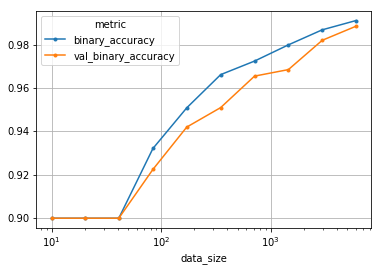

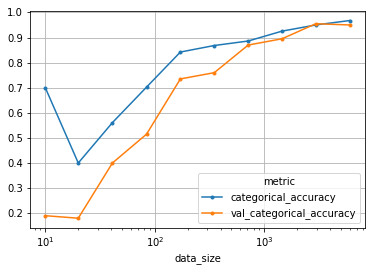

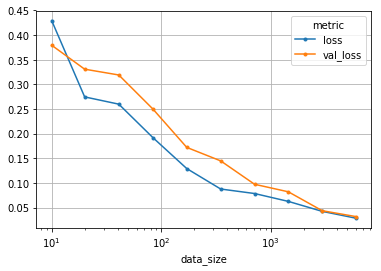

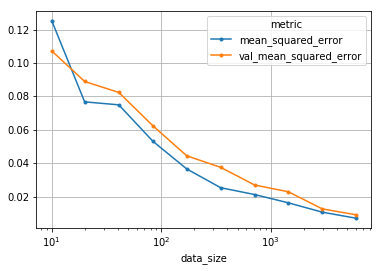

In [182]:
learning_curve.plot()